In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import ase
import time
import numpy as np
import ase.io as aio
import scipy.io as sio
import matplotlib.pyplot as plt
import poremks.porosity as pore
import poremks.correlations as corr
import poremks.grid_generator as gen
from poremks.helpers import write2vtk
from toolz.curried import pipe, curry

In [3]:
def get_radii(atom_id, radius_type="vdw"):
    """
    atom_id: element symbol
    radius_type = "vdw" for Van der Waals or "cov" for Covalent
    """
    import pandas as pd
    
    xl = pd.ExcelFile("Elemental_Radii.xlsx")
    df = xl.parse(sheet_name=0, header = 2, index_col=1)
    
    if radius_type is "cov":
        key = 6
    elif radius_type is "vdw":
        key = 7
    else:
        raise ValueError("radius_type not supported")
    if atom_id in df.index:
        return df.loc[atom_id][key]
    else:
        raise ValueError("Elemental symbol not found")

## Load Structure of Interest

### For an amorphous hydrocarbon macromolecular structure

In [4]:
cif = "EFK_50A_0.80.xyz"
rep = [1, 1, 1]
fname = os.path.join("hydrocarbons", "EFK_50A_0.80.xyz")

### For a 3D bulk zeolite

In [5]:
cif = "MFI.cif"
fname = os.path.join("iza_zeolites", cif)
rep = [2]*3
# radii={"Si":1.35, "O": 1.35} # from the zeo++ paper

### Load the structure information using ase library as an atom object

In [6]:
atom = pipe(fname, 
            lambda fname: aio.read(fname), 
            lambda x: x.repeat(rep))

atom_ids = sorted(np.unique(atom.get_chemical_symbols()))

radii = {}
for idx in atom_ids:
    radii[idx] = get_radii(idx)

print("No. of atoms in the structure: %d" % len(atom))

No. of atoms in the structure: 2304


## Generate Voxelized Representation of the Pore Structure

In [7]:
%%time
len_pixel = 10
S, S_list, box_dim = gen.grid_maker(atom, len_pixel=len_pixel, atomic_radii=radii, full=False, fft=False)
print(S.shape)

(403, 396, 264)
CPU times: user 6.51 s, sys: 1.05 s, total: 7.56 s
Wall time: 7.36 s


### Compute Conventional Pore Metrics - PLD and LCD

In [8]:
strt = time.time()
padval = ((1, 1), (1, 1), (0, 0)) 
S_dgrid = pipe(S,
               lambda s: np.pad(s, padval, 'constant', constant_values=0),
               lambda s: pore.dgrid(s, len_pixel=len_pixel))
end = time.time()
print("distance grid computation time: %1.3fs"%(end-strt))

strt = time.time()
pld  = pore.get_pld(S_dgrid)
end  = time.time()
print("PLD: %1.3f" % pld)
print("PLD computation time: %1.3fs"%(end-strt))

strt = time.time()
lcd  = pore.get_lcd(S_dgrid)
end  = time.time()
print("LCD: %1.3f" % lcd)
print("LCD computation time: %1.3fs"%(end-strt))

distance grid computation time: 3.798s
PLD: 3.883
PLD computation time: 2.863s
LCD: 6.353
LCD computation time: 0.010s


### For PLD in a different direction

In [9]:
%%time
padval = ((1, 1), (1, 1), (0, 0)) 
pld = pipe(S, 
           lambda s: np.rot90(s, axes=(0,2)),
           lambda s: np.pad(s, padval, 'constant', constant_values=0),
           lambda s: pore.dgrid(s, len_pixel=len_pixel),
           lambda s: pore.get_pld(s))
print(pld)

4.3046875
CPU times: user 6.13 s, sys: 1.5 s, total: 7.63 s
Wall time: 7.5 s


# Geometric and Statistical analysis of diffusion pathways

Compute the fraction of the void space within the molecular structure that is accessible to a probe molecule traversing in a particular direction

- Convert admissible coordinates to graph structure
 - generate adjacency matrix from graph structure
 - use adjacency matrix to identify shortest paths
 - use a Shortest Path heuristic on the adjacency matrix to prune the medial axis network of dead ends.
 - for the pruned path, use eculidean distance from nearest atoms at each path voxel as a metric of pore size distribution

### Extract pore volume accessible to a probe moleucle

In [10]:
strt = time.time()
padval = ((0, 0), (0, 0), (0, 0)) 
S_dgrid = pipe(S,
               lambda s: np.pad(s, padval, 'constant', constant_values=0),
               lambda s: pore.dgrid(s, len_pixel=len_pixel))
end = time.time()

strt = time.time()
S_1 = (pore.gen_cleanPore(S_dgrid, r_probe=1.0, r_min=2.5, len_pixel=len_pixel) > 0) * 1
end = time.time()
print("Pore Cleaning Computation Time: %1.3fs" % (end-strt))

Pore Cleaning Computation Time: 0.917s


In [11]:
%%time
# To generate vtk file of the accessible void region for visualization
write2vtk(S_1, "%s_pore.vtk" % cif)

CPU times: user 12.7 s, sys: 1.38 s, total: 14 s
Wall time: 17.2 s


### Compute 2 Point Statistics of the accessible pore region

In [12]:
# %%time
# GG_poreAcc = corr.compute_statistics(boundary="nonperiodic", corrtype="auto", cutoff=120, args0=S_1)

In [13]:
%%time
# GG_poreAll = corr.compute_statistics(boundary="nonperiodic", corrtype="auto", cutoff=120, args0=S)
# GG_pore_O  = corr.compute_statistics(boundary="nonperiodic", corrtype="cross", cutoff=120, args0=S, args1=S_list[0])
# GG_pore_Si = corr.compute_statistics(boundary="nonperiodic", corrtype="cross", cutoff=120, args0=S, args1=S_list[1])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.53 µs


In [14]:
# To generate vtk file of the accessible void region for visualization
# write2vtk(GG_poreAll, "%s_pore_stat.vtk" % cif)

### Generate skeletonized representation of pore structure

In [15]:
strt = time.time()
S_2 = pipe(S_1, 
           lambda x: np.pad(x, pad_width=((0,0),(0,0),(len_pixel, len_pixel)), mode = "constant", constant_values=1), 
           lambda x: pore.gen_medialAxis(x)[:,:,len_pixel:-len_pixel])
end = time.time()
print("Medial Path Computation Time: %1.3fs" % (end-strt))

Medial Path Computation Time: 13.179s


### Compute Shortest Paths connecting opposing faces of the molecular structure

In [16]:
strt = time.time()
S_3, paths = pore.gen_throughPath(S_2, depth=1)
end = time.time()
print("Through Path Computation Time: %1.3fs" % (end-strt))
print("Mean and setdev of path lengths: %1.3f, %1.3f" % (np.mean(paths), np.std(paths)))

Through Path Computation Time: 9.820s
Mean and setdev of path lengths: 3.606, 0.438


In [17]:
n_channels = len(pore.return_labelled(S_1)[-1])
print("No. of unique channels: %d" % n_channels)

No. of unique channels: 1


In [18]:
%%time
# to generate vtk file of the medial path for visualization
write2vtk(S_3, "%s_through_path.vtk" % cif)

CPU times: user 14.1 s, sys: 1.8 s, total: 15.9 s
Wall time: 19.3 s


### Compute accessible surface area and volume

In [19]:
asa = pore.get_asa(S_1, len_pixel=10)
print("Probe Accessible Surface Area: %1.3f" % asa)
av = np.count_nonzero(S_1) * (1 / len_pixel)**3
print("Probe Accessible Volume: %1.3f" % av)

Probe Accessible Surface Area: 10701.460
Probe Accessible Volume: 5401.031


### Compute pore size distribution

In [20]:
psd = S_dgrid[S_2==1]
print("Mean and setdev of pore size distribution: %1.3f, %1.3f" % (np.mean(psd), np.std(psd)))

Mean and setdev of pore size distribution: 2.051, 0.397


In [21]:
dim = np.asarray(S.shape) / len_pixel
print("dimensions of the structure: ", dim)

dimensions of the structure:  [40.3 39.6 26.4]


### Visualize path length distribution (length in angstrom)

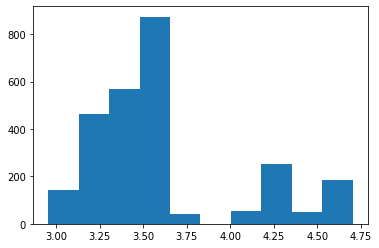

In [22]:
plt.hist(paths)
plt.show()

### Visualize pore size distribution (length in angstrom)

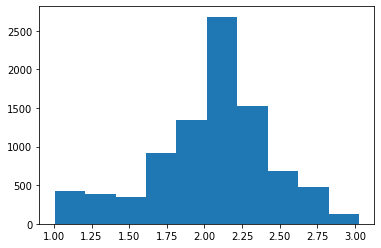

In [23]:
plt.hist(psd)
plt.show()